# k-NN Classification

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [5]:
# Read in processed data
df = pd.read_csv('./data/data_processed.csv')
df.head()

,race,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,pt_admission_source_2_ct,pt_admission_source_3_ct,pt_time_tot,pt_lab_procedure_tot,pt_procedure_tot,pt_med_tot,pt_outp_tot,pt_inp_tot,pt_ER_tot,pt_diag_tot
0,Caucasian,0,1,41,0,1,0,0,0,1,...,0,0,1,41,0,1,0,0,0,1
1,Caucasian,1,3,59,0,18,0,0,0,9,...,0,0,3,59,0,18,0,0,0,9
2,AfricanAmerican,2,2,11,5,13,2,0,1,6,...,0,0,2,11,5,13,2,1,0,6
3,Caucasian,3,2,44,1,16,0,0,0,7,...,0,0,2,44,1,16,0,0,0,7
4,Caucasian,4,1,51,0,8,0,0,0,5,...,0,0,1,51,0,8,0,0,0,5


In [6]:
# Check the target column
print(df['readmitted'])
print('readmitted is column number ', df.columns.get_loc('readmitted'))

0         NO
1        >30
2         NO
3         NO
4         NO
        ... 
97103    >30
97104     NO
97105     NO
97106     NO
97107     NO
Name: readmitted, Length: 97108, dtype: object
readmitted is column number  20


Our initial goal was to predict for 30 day hospital readmissions, so we combine the values 'NO' and '>30' in the column 'readmitted' and relabel the value with the integer 0.
This is because there is no readmission for the patient in less than 30 days.

The value '<30' has been relabeled with the integer 1.

In [7]:
df.loc[(df['readmitted'] == 'NO') | (df['readmitted'] == '>30'), 'readmitted'] = int(0)
#df.loc[df['readmitted'] == '>30', 'readmitted'] = int(0)
df.loc[(df['readmitted'] == '<30'), 'readmitted'] = int(1)

# Make sure column values are integers, necessary for classification algorithms later
df['readmitted'] = df['readmitted'].astype('int')
print(df['readmitted'].dtype)

int64


In [8]:
# List all columns in dataset
df.columns 

Index(['race', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'diabetesMed',
       'readmitted', 'admission_urg_ind', 'admission_nurg_ind',
       'admission_none_ind', 'discharge_shortterm_ind',
       'discharge_longterm_ind', 'discharge_none_ind', 'admission_source_1',
       'admission_source_2', 'admission_source_3', 'caucasian_ind',
       'africanamerican_ind', 'hispanic_ind', 'asian_ind', 'otherrace_ind',
       'female_ind', 'male_ind', 'readmit_diag_1', 'readmit_diag_2',
       'readmit_diag_3', 'readmit_diag_4', 'readmit_diag_5', 'readmit_diag_6',
       'readmit_diag_7', 'readmit_diag_8', 'readmit_diag_9', 'readmit_diag_10',
       'readmit_diag_11', 'readmit_diag_12', 'readmit_diag_13',
       'pt_ris

In [9]:
#EDIT THIS CELL TO AUTO REMOVE race AND readmitted FROM THIS LIST
# Single out which columns will be usede to predict readmit rate
features = ['age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'diabetesMed',
       'admission_urg_ind', 'admission_nurg_ind',
       'admission_none_ind', 'discharge_shortterm_ind',
       'discharge_longterm_ind', 'discharge_none_ind', 'admission_source_1',
       'admission_source_2', 'admission_source_3', 'caucasian_ind',
       'africanamerican_ind', 'hispanic_ind', 'asian_ind', 'otherrace_ind',
       'female_ind', 'male_ind', 'readmit_diag_1', 'readmit_diag_2',
       'readmit_diag_3', 'readmit_diag_4', 'readmit_diag_5', 'readmit_diag_6',
       'readmit_diag_7', 'readmit_diag_8', 'readmit_diag_9', 'readmit_diag_10',
       'readmit_diag_11', 'readmit_diag_12', 'readmit_diag_13',
       'pt_risk_diag_ct', 'pt_diag_ct', 'd_external_index',
       'd_supplementary_index', 'd_infect_ind', 'd_neoplasm_ind',
       'd_endocrine_ind', 'd_blood_ind', 'd_mental_ind', 'd_nervous_ind',
       'd_circulatory_ind', 'd_respiratory_ind', 'd_digestive_ind',
       'd_genitourinary_ind', 'd_pegnancy_ind', 'd_skin_ind', 'd_musculo_ind',
       'd_congenital_ind', 'd_perinatal_ind', 'd_symptoms_ind', 'd_injury_ind',
       'dia_med_change_ind', 'dia_med_nochange_ind', 'pt_admission_urg_ct',
       'admission_nurg_ct', 'admission_none_ct', 'pt_discharge_shortterm_ct',
       'pt_discharge_longterm_ct', 'pt_discharge_none_ct',
       'pt_admission_source_1_ct', 'pt_admission_source_2_ct',
       'pt_admission_source_3_ct', 'pt_time_tot', 'pt_lab_procedure_tot',
       'pt_procedure_tot', 'pt_med_tot', 'pt_outp_tot', 'pt_inp_tot',
       'pt_ER_tot', 'pt_diag_tot']


In [10]:
from sklearn.model_selection import train_test_split

#Creating an additional column to stratify over 2 variables
df['strat_col'] = df['race'].astype(str) + "_" + df['readmitted'].astype(str)
train, test = train_test_split(df, test_size=.2, stratify=df['strat_col'], random_state=42)
train = train.drop(columns=['race','strat_col'])
test = test.drop(columns=['race','strat_col'])

We first use knn classification. On the training data, we perform a 5-fold split, and compute the accuracy and confusion matrices for the model at each split.

We need to find the optimum k value.

In [20]:
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [13]:
%%time

n_splits = 2
kfold = KFold(n_splits, shuffle = True)

#Consider odd k values for binary classification
ave_auc = {k:[] for k in range(5,54,2)}

for k in range(5,54,2):
    
    pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(k))])
    aucs = [] #Holds auc score of model at each split, to be averaged later

    for s_train, s_test in kfold.split(train):

        train_features = train.iloc[s_train][features]
        test_features = train.iloc[s_test][features]

        train_target = train.iloc[s_train]['readmitted']
        test_target = train.iloc[s_test]['readmitted']

        pipe.fit(train_features, train_target)

        probs = pipe.predict_proba(test_features)
        y_pred = pipe.predict(test_features)

        false_pos_rate, true_pos_rate, threshold = roc_curve(test_target, probs[:,1])
        auc_scr = auc(false_pos_rate,true_pos_rate)
        
        aucs.append(auc_scr)

    ave_auc[k].append(sum(aucs)/len(aucs))
   

for k in ave_auc:
    print('When the knn parameter k is ', k, ', the average accuracy among the splits is ', ave_auc[k][0])


When the knn parameter k is  5 , the average accuracy among the splits is  0.5984772561853666
When the knn parameter k is  7 , the average accuracy among the splits is  0.6202350298488688
When the knn parameter k is  9 , the average accuracy among the splits is  0.6289977883136776
When the knn parameter k is  11 , the average accuracy among the splits is  0.6421162117134507
When the knn parameter k is  13 , the average accuracy among the splits is  0.6427438954607904
When the knn parameter k is  15 , the average accuracy among the splits is  0.6494824300277882
When the knn parameter k is  17 , the average accuracy among the splits is  0.6508023970095594
When the knn parameter k is  19 , the average accuracy among the splits is  0.6557948075226652
When the knn parameter k is  21 , the average accuracy among the splits is  0.6641793572723759
When the knn parameter k is  23 , the average accuracy among the splits is  0.6598136768200843
When the knn parameter k is  25 , the average accurac

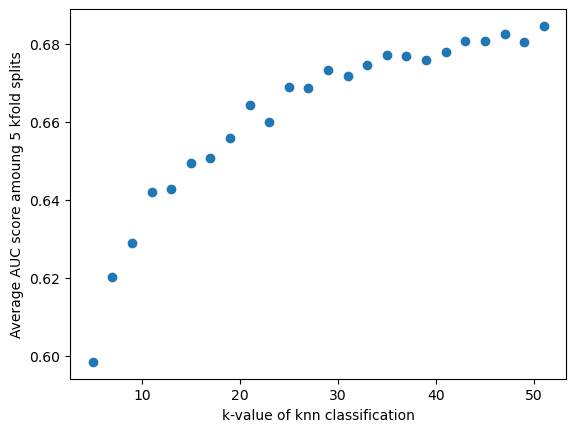

In [14]:
k_values = [n for n in range(5,52,2)]
aucs_plt = [ave_auc[n][0] for n in range(5,52,2)]
plt.scatter(k_values, aucs_plt)
plt.xlabel('k-value of knn classification')
plt.ylabel('Average AUC score amoung 5 kfold splits')
plt.show()

In [28]:
n_splits = 5
current_split = 0
metrics={n:[] for n in range(0,n_splits)}

pipe = Pipeline([('scale', MinMaxScaler()), ('knn', KNeighborsClassifier(53))]) #choosing k=53 
pipe_fin = pipe
auc_scr_old = 0

kfold = KFold(n_splits, shuffle = True, random_state=42)

for s_train, s_test in kfold.split(train):

    train_features = train.iloc[s_train][features]
    test_features = train.iloc[s_test][features]

    train_target = train.iloc[s_train]['readmitted']
    test_target = train.iloc[s_test]['readmitted']

    pipe.fit(train_features,train_target)
    metrics[current_split].append(accuracy_score(pipe.predict(test_features), test_target))
    metrics[current_split].append(confusion_matrix(pipe.predict(test_features), test_target))

    probs = pipe.predict_proba(test_features)
    y_pred = pipe.predict(test_features)

    false_pos_rate, true_pos_rate, threshold = roc_curve(test_target, probs[:,1])
    auc_scr = auc(false_pos_rate,true_pos_rate)
    metrics[current_split].append(auc_scr)

    if auc_scr > auc_scr_old:
        pipe_fin = pipe
        auc_scr_old = auc_scr

    current_split += 1

for k in range(0,5):
    print('The accuracy of split ', k, ' is ', metrics[k][0], ' AUC score is ', metrics[k][2])


The accuracy of split  0  is  0.8859570086240185  AUC score is  0.6079295750437517
The accuracy of split  1  is  0.884018793846946  AUC score is  0.6017029596235979
The accuracy of split  2  is  0.8861427560018021  AUC score is  0.6025660723937
The accuracy of split  3  is  0.8844049687841926  AUC score is  0.6135577126360529
The accuracy of split  4  is  0.8867863808972131  AUC score is  0.6028099511044696


From the results, it seems unlikey accuracy can be imporved beyond about 88% just by varying the hyperparametter.

In [29]:
probs = pipe_fin.predict_proba(test[features])
y_pred = (probs[:, 1]>=0.5)

Confusion Matrix:
[[17194     3]
 [ 2220     5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17197
           1       0.62      0.00      0.00      2225

    accuracy                           0.89     19422
   macro avg       0.76      0.50      0.47     19422
weighted avg       0.86      0.89      0.83     19422

Mean squared error =  0.1144578313253012
Accuracy =  0.8855421686746988
ROC AUC score =  0.6115986391668784


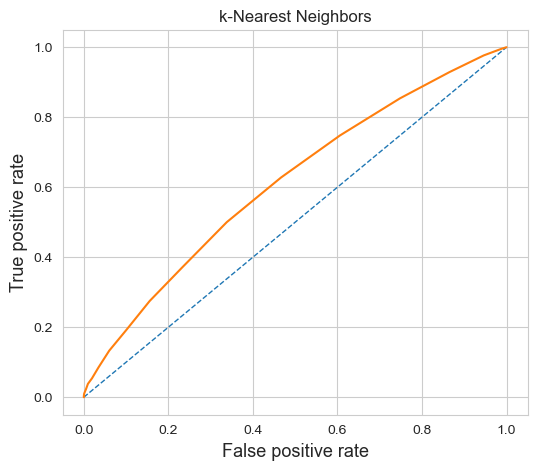

In [30]:
# --- Evaluate Model ---
#y_pred = model.predict(X_test)
y_test = test['readmitted']
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probs[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_data = pd.DataFrame({'X': false_pos_rate.tolist(), 'Y': true_pos_rate.tolist()})
roc_data.to_csv('./figs/plot_data/roc_curve_kNN.csv', index=False)
    

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)
print("ROC AUC score = ",roc_auc)

plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], '--', lw=1)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('k-Nearest Neighbors')
plt.show()

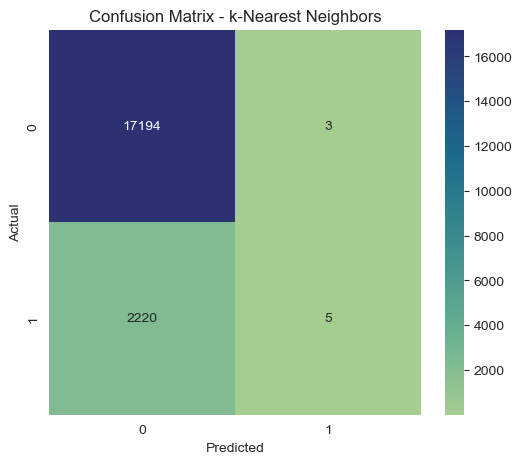

Confusion Matrix:
 [[17194     3]
 [ 2220     5]]


In [31]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - k-Nearest Neighbors')

plt.savefig('./figs/conf_mat_kNN.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)


Now we use xgboost to classify the readmits. We still use 5 splits in kfold.

We measure performance by computing accuracy and confusion matrix. By these metrics, xgboost is very simmilar to knn.

In [40]:
import xgboost as xgb

xgb_class = xgb.XGBClassifier(eval_metric='logloss')

n_splits = 5
current_split = 0
boost_metrics={n:[] for n in range(0,n_splits)}

for s_train, s_test in kfold.split(train):

    train_features = train.iloc[s_train][features]
    test_features = train.iloc[s_test][features]

    train_target = train.iloc[s_train]['readmitted']
    test_target = train.iloc[s_test]['readmitted']

    xgb_class.fit(train_features, train_target)
    boost_metrics[current_split].append(accuracy_score(xgb_class.predict(test_features), test_target))
    boost_metrics[current_split].append(confusion_matrix(xgb_class.predict(test_features), test_target))
    
    probs = xgb_class.predict_proba(test_features)
    y_pred = (probs[:,1]>=0.5)

    false_pos_rate, true_pos_rate, threshold = roc_curve(test_target, probs[:,1])
    auc_scr = auc(false_pos_rate,true_pos_rate)
    boost_metrics[current_split].append(auc_scr)

    current_split += 1

    
for k in range(0,4):
    print('The accuracy of split ', k, ' is ', boost_metrics[k][0], ' AUC score is ', boost_metrics[k][2])


The accuracy of split  0  is  0.8843480499420775  AUC score is  0.8116766634441225
The accuracy of split  1  is  0.8809293943489734  AUC score is  0.8150980623942459
The accuracy of split  2  is  0.8815730192443844  AUC score is  0.8044257556861388
The accuracy of split  3  is  0.8851773186586858  AUC score is  0.8189589798297178
